### Imports and Installations

In [1]:
import os
import torch
import numpy as np
import pandas as pd
from torch import nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, confusion_matrix
from transformers import BertTokenizer, BertModel
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
import matplotlib.pyplot as plt
import seaborn as sns

2025-04-14 12:08:53.834597: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744632534.265906      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744632534.406893      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
os.makedirs('confusion_matrices', exist_ok=True)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


### Caption Dataset
CaptionDataset
The CaptionDataset class inherits from PyTorch's Dataset class and serves as the foundation for preparing caption classification data. It takes a pandas DataFrame containing caption data, a BERT tokenizer for text processing, and an optional maximum sequence length parameter (defaulting to 128 tokens). Within this class, the __len__() method returns the total number of samples in the dataset. The __getitem__(idx) method is responsible for retrieving individual samples, where each sample consists of an original caption, a generated caption, and a perturbation level. These elements are combined into a single text string with the format <original_caption> [SEP] <generated_caption> [SEP] <perturbation_percentage>, which is then tokenized using the BERT tokenizer before being returned with its corresponding label.

In [4]:
class CaptionDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length=128):
        """
        Dataset for caption classification.

        Args:
            dataframe (pd.DataFrame): DataFrame containing caption data
            tokenizer: Tokenizer for text processing
            max_length (int): Maximum sequence length
        """
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]

        # Concatenate original caption, generated caption, and perturbation level
        original_caption = str(row['original'])
        generated_caption = str(row['generated'])
        perturbation = str(row['perturbation'])

        # Format: <original_caption> <SEP> <generated_caption> <SEP> <perturbation_percentage>
        text = f"{original_caption} [SEP] {generated_caption} [SEP] {perturbation}"

        # Tokenize
        encoding = self.tokenizer(
            text,
            padding='max_length',
            truncation=True,
            max_length=self.max_length,
            return_tensors='pt'
        )

        # Get label (1 for SmolVLM, 0 for Custom)
        label = 1 if row['model'] == 'smolvlm' else 0

        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'token_type_ids': encoding['token_type_ids'].squeeze(),
            'label': torch.tensor(label, dtype=torch.long)
        }

### Caption Classifier
The CaptionClassifier class extends PyTorch's nn.Module and implements a BERT-based neural network for classifying captions by their source model. It accepts a pretrained BERT model name (defaulting to 'bert-base-uncased') and a dropout rate parameter (defaulting to 0.3) for regularization. The architecture consists of a pretrained BERT model followed by a classification head comprising a dropout layer, a linear layer that reduces dimensions from BERT's hidden size to 256 neurons, a ReLU activation function, another dropout layer, and finally a linear layer that outputs two logits for binary classification. The forward method processes input token IDs, attention masks, and token type IDs through the BERT model, extracts the pooled output from the [CLS] token, applies dropout, and passes the result through the classification layers to produce logits.


In [5]:
class CaptionClassifier(nn.Module):
    def __init__(self, bert_model_name='bert-base-uncased', dropout_rate=0.3):
        """
        BERT-based classifier for identifying which model generated a caption.

        Args:
            bert_model_name (str): Name of the pretrained BERT model
            dropout_rate (float): Dropout rate for the classifier
        """
        super(CaptionClassifier, self).__init__()

        # Load pretrained BERT model
        self.bert = BertModel.from_pretrained(bert_model_name)

        # Get the hidden size from BERT config
        hidden_size = self.bert.config.hidden_size

        # Classification layers
        self.dropout = nn.Dropout(dropout_rate)
        self.classifier = nn.Sequential(
            nn.Linear(hidden_size, 256),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(256, 2)  # Binary classification
        )

    def forward(self, input_ids, attention_mask, token_type_ids=None):
        """
        Forward pass of the model.

        Args:
            input_ids (torch.Tensor): Token IDs
            attention_mask (torch.Tensor): Attention mask
            token_type_ids (torch.Tensor, optional): Token type IDs

        Returns:
            torch.Tensor: Output logits
        """
        # Pass inputs through BERT
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids
        )

        # Get the [CLS] token representation
        pooled_output = outputs.pooler_output

        # Apply dropout and pass through classifier
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)

        return logits

### Training The Classifier Model
The train_classifier function handles the complete training process for the caption classifier model. It takes six parameters: the model to be trained, a data loader containing training samples, an optimizer (typically AdamW), a loss criterion (CrossEntropyLoss), a computing device ('cuda' or 'cpu'), and the number of training epochs (defaulting to 4). During execution, this function iterates through the specified number of epochs, processing batches of data in each epoch. For every batch, it performs a forward pass through the model, calculates the loss, computes gradients through backpropagation, applies gradient clipping to prevent exploding gradients, and updates the model parameters. Throughout training, it tracks metrics such as loss and accuracy, providing progress updates every few batches. After completing each epoch, the function calculates average epoch loss and accuracy, then saves a model checkpoint containing the model state, optimizer state, and loss information.

In [6]:
def train_classifier(model, dataloader, optimizer, criterion, device, epochs=4):
    """
    Train the BERT-based caption classifier.

    Args:
        model (nn.Module): Custom image captioning model.
        dataloader (DataLoader): Training data loader.
        optimizer: Optimizer (e.g., Adam).
        criterion (Loss): Loss function.
        device (str): Device to use ('cuda' or 'cpu').
        epochs (int): Number of epochs.
    """
    model.train()
    print("Starting training...")

    for epoch in range(epochs):
        epoch_loss = 0
        batch_count = 0
        correct_predictions = 0
        total_predictions = 0

        for batch in dataloader:
            batch_count += 1

            # Move batch data to device
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            token_type_ids = batch['token_type_ids'].to(device)
            labels = batch['label'].to(device)

            # Forward pass
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                token_type_ids=token_type_ids
            )

            # Calculate loss
            loss = criterion(outputs, labels)

            # Calculate accuracy
            _, preds = torch.max(outputs, dim=1)
            correct_predictions += torch.sum(preds == labels)
            total_predictions += labels.shape[0]

            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()

            # Gradient clipping to prevent exploding gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()

            epoch_loss += loss.item()

            # Print progress
            if batch_count % 5 == 0:
                print(f"Epoch {epoch+1}/{epochs}, Batch {batch_count}/{len(dataloader)}, Loss: {loss.item():.4f}")

        avg_epoch_loss = epoch_loss / len(dataloader)
        accuracy = correct_predictions.float() / total_predictions

        print(f"Epoch {epoch+1}/{epochs} completed. Average Loss: {avg_epoch_loss:.4f}, Accuracy: {accuracy:.4f}")

        # Save checkpoint after each epoch
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': avg_epoch_loss,
        }, f'classifier_checkpoint_epoch_{epoch+1}.pth')


### Evaluating Model Performance
The evaluate_classifier function assesses the performance of a trained classification model on a provided dataset. It accepts four parameters: the trained model, a data loader containing evaluation samples, a computing device, and an optional name parameter for saving the confusion matrix. When called, this function sets the model to evaluation mode and processes all batches in the data loader without computing gradients. It collects predictions and true labels for all samples, then calculates several evaluation metrics including accuracy, precision, recall, and F1 score using scikit-learn functions. Additionally, it generates a confusion matrix visualization and saves it to a file if a name is provided. The function returns a dictionary containing all computed metrics and prints a summary of the evaluation results to the console.

In [7]:
def evaluate_classifier(model, dataloader, device, name=""):
    """
    Evaluate the classification model.

    Args:
        model (nn.Module): Trained model.
        dataloader (DataLoader): Test data loader.
        device (str): 'cuda' or 'cpu'.
        name (str): Optional name for saving confusion matrix

    Returns:
        dict: Precision, Recall and F1 scores for the test set.
    """
    model.eval()

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in dataloader:
            # Move batch data to device
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            token_type_ids = batch['token_type_ids'].to(device)
            labels = batch['label'].to(device)

            # Forward pass
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                token_type_ids=token_type_ids
            )

            # Get predictions
            _, preds = torch.max(outputs, dim=1)

            # Store predictions and labels
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate metrics (macro precision, recall, and F1)
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_labels, all_preds, average='macro'
    )
    accuracy = accuracy_score(all_labels, all_preds)

    results = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

    print(f"Evaluation Results:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Macro Precision: {precision:.4f}")
    print(f"Macro Recall: {recall:.4f}")
    print(f"Macro F1 Score: {f1:.4f}")

    # Generate a confusion matrix for additional analysis
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Custom Model', 'SmolVLM'],
                yticklabels=['Custom Model', 'SmolVLM'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')

    # Save confusion matrix with name if provided
    if name:
        filename = f'confusion_matrices/confusion_matrix_{name}.png'
    else:
        filename = 'confusion_matrices/confusion_matrix.png'

    plt.savefig(filename)
    plt.close()  # Close to avoid displaying in Kaggle

    return results


#### Checking for files if they exist


In [8]:
perturbation_levels = [0, 10, 50, 80]
model_types = ['custom', 'smolvlm']

# DEBUG: Check if files exist before attempting to load
print("Checking if all data files exist:")
for model in model_types:
    for level in perturbation_levels:
        level_decimal = {0: 0.0, 10: 0.1, 50: 0.5, 80: 0.8}[level]
        file_path = f'/kaggle/input/perturbation-data-dl/perturbation_data_{model}_{level_decimal}.csv'
        exists = os.path.exists(file_path)
        print(f"File {file_path} exists: {exists}")

# Dictionary to store all dataframes
all_dfs = {}
combined_df = pd.DataFrame()


Checking if all data files exist:
File /kaggle/input/perturbation-data-dl/perturbation_data_custom_0.0.csv exists: True
File /kaggle/input/perturbation-data-dl/perturbation_data_custom_0.1.csv exists: True
File /kaggle/input/perturbation-data-dl/perturbation_data_custom_0.5.csv exists: True
File /kaggle/input/perturbation-data-dl/perturbation_data_custom_0.8.csv exists: True
File /kaggle/input/perturbation-data-dl/perturbation_data_smolvlm_0.0.csv exists: True
File /kaggle/input/perturbation-data-dl/perturbation_data_smolvlm_0.1.csv exists: True
File /kaggle/input/perturbation-data-dl/perturbation_data_smolvlm_0.5.csv exists: True
File /kaggle/input/perturbation-data-dl/perturbation_data_smolvlm_0.8.csv exists: True


### Combining perturbation CSV's accross different models(SMOLVLM and CUSTOM)

In [9]:
for model in model_types:
    for level in perturbation_levels:
        try:
            # Map the level to the corresponding decimal format in the filename
            level_decimal = {0: 0.0, 10: 0.1, 50: 0.5, 80: 0.8}[level]

            # Path for Kaggle notebooks
            file_path = f'/kaggle/input/perturbation-data-dl/perturbation_data_{model}_{level_decimal}.csv'

            print(f"Attempting to load: {file_path}")

            # Check if file exists
            if not os.path.exists(file_path):
                print(f"Warning: File {file_path} does not exist. Skipping...")
                continue

            df = pd.read_csv(file_path)

            # IMPORTANT: Explicitly set perturbation and model columns
            df['perturbation'] = int(level)
            df['model'] = model

            # Debug print sizes before merging
            print(f"Loaded {model} {level}% data: {len(df)} rows")

            # Store in dictionary for potential separate analysis
            all_dfs[f"{model}_{level}"] = df

            # Append to combined dataframe
            combined_df = pd.concat([combined_df, df], ignore_index=True)

            print(f"Combined dataframe now has {len(combined_df)} rows")
        except Exception as e:
            print(f"Error loading {model} {level}% data: {str(e)}")
print("Distribution of perturbation levels in combined data:")
print(combined_df['perturbation'].value_counts())

# Fill any missing values
combined_df.fillna("", inplace=True)


Attempting to load: /kaggle/input/perturbation-data-dl/perturbation_data_custom_0.0.csv
Loaded custom 0% data: 928 rows
Combined dataframe now has 928 rows
Attempting to load: /kaggle/input/perturbation-data-dl/perturbation_data_custom_0.1.csv
Loaded custom 10% data: 928 rows
Combined dataframe now has 1856 rows
Attempting to load: /kaggle/input/perturbation-data-dl/perturbation_data_custom_0.5.csv
Loaded custom 50% data: 928 rows
Combined dataframe now has 2784 rows
Attempting to load: /kaggle/input/perturbation-data-dl/perturbation_data_custom_0.8.csv
Loaded custom 80% data: 928 rows
Combined dataframe now has 3712 rows
Attempting to load: /kaggle/input/perturbation-data-dl/perturbation_data_smolvlm_0.0.csv
Loaded smolvlm 0% data: 928 rows
Combined dataframe now has 4640 rows
Attempting to load: /kaggle/input/perturbation-data-dl/perturbation_data_smolvlm_0.1.csv
Loaded smolvlm 10% data: 928 rows
Combined dataframe now has 5568 rows
Attempting to load: /kaggle/input/perturbation-data

### Loading Bert Tokenizer 

In [10]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

### DataLoading for Train, Test, Val

In [11]:
unique_images = combined_df['image_path'].unique()
print(f"Total unique images: {len(unique_images)}")

# Split image filenames - 70% train, 10% val, 20% test
train_val_images, test_images = train_test_split(unique_images, test_size=0.2, random_state=42)
train_images, val_images = train_test_split(train_val_images, test_size=0.125, random_state=42)  # 0.125 of 80% = 10% overall

# Create splits based on image filenames
train_df = combined_df[combined_df['image_path'].isin(train_images)]
val_df = combined_df[combined_df['image_path'].isin(val_images)]
test_df = combined_df[combined_df['image_path'].isin(test_images)]

# Debug - Show distribution of perturbation levels in split datasets
print("\nDistribution of perturbation levels in train/val/test sets:")
print("Train:", train_df['perturbation'].value_counts())
print("Validation:", val_df['perturbation'].value_counts())
print("Test:", test_df['perturbation'].value_counts())

# Debug - Show distribution of model types in split datasets
print("\nDistribution of model types in train/val/test sets:")
print("Train:", train_df['model'].value_counts())
print("Validation:", val_df['model'].value_counts())
print("Test:", test_df['model'].value_counts())

print(f"Train set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")
print(f"Test set size: {len(test_df)}")

# Create datasets
train_dataset = CaptionDataset(train_df, tokenizer)
val_dataset = CaptionDataset(val_df, tokenizer)
test_dataset = CaptionDataset(test_df, tokenizer)

# Create data loaders
train_dataloader = DataLoader(
    train_dataset,
    batch_size=16,
    sampler=RandomSampler(train_dataset)
)

val_dataloader = DataLoader(
    val_dataset,
    batch_size=16,
    sampler=SequentialSampler(val_dataset)
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=16,
    sampler=SequentialSampler(test_dataset)
)


Total unique images: 928

Distribution of perturbation levels in train/val/test sets:
Train: perturbation
0     1298
10    1298
50    1298
80    1298
Name: count, dtype: int64
Validation: perturbation
0     186
10    186
50    186
80    186
Name: count, dtype: int64
Test: perturbation
0     372
10    372
50    372
80    372
Name: count, dtype: int64

Distribution of model types in train/val/test sets:
Train: model
custom     2596
smolvlm    2596
Name: count, dtype: int64
Validation: model
custom     372
smolvlm    372
Name: count, dtype: int64
Test: model
custom     744
smolvlm    744
Name: count, dtype: int64
Train set size: 5192
Validation set size: 744
Test set size: 1488


### Training the Classification Model
Trainng of the Bert based classification model.

                    Validation Set         Test Set
                
    Accuracy            0.9785              0.9839

    Macro Precision:    0.9794              0.9844

    Macro Recall:       0.9785              0.9839

    Macro F1 Score:     0.9785              0.9839



In [12]:
print("Initializing model...")
model = CaptionClassifier().to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)

# Train the model
print("Training model...")
train_classifier(
    model=model,
    dataloader=train_dataloader,
    optimizer=optimizer,
    criterion=criterion,
    device=device,
    epochs=5
)

print("\nEvaluating on validation set...")
val_results = evaluate_classifier(model, val_dataloader, device, "validation")

# Evaluate on test set
print("\nEvaluating on test set...")
test_results = evaluate_classifier(model, test_dataloader, device, "test")

# Save the final model
torch.save(model.state_dict(), 'caption_classifier_final.pth')

Initializing model...


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Training model...
Starting training...
Epoch 1/5, Batch 5/325, Loss: 0.6453
Epoch 1/5, Batch 10/325, Loss: 0.6038
Epoch 1/5, Batch 15/325, Loss: 0.4956
Epoch 1/5, Batch 20/325, Loss: 0.3350
Epoch 1/5, Batch 25/325, Loss: 0.2091
Epoch 1/5, Batch 30/325, Loss: 0.1631
Epoch 1/5, Batch 35/325, Loss: 0.1387
Epoch 1/5, Batch 40/325, Loss: 0.0902
Epoch 1/5, Batch 45/325, Loss: 0.0693
Epoch 1/5, Batch 50/325, Loss: 0.0545
Epoch 1/5, Batch 55/325, Loss: 0.0502
Epoch 1/5, Batch 60/325, Loss: 0.0351
Epoch 1/5, Batch 65/325, Loss: 0.0239
Epoch 1/5, Batch 70/325, Loss: 0.0211
Epoch 1/5, Batch 75/325, Loss: 0.0228
Epoch 1/5, Batch 80/325, Loss: 0.0224
Epoch 1/5, Batch 85/325, Loss: 0.0178
Epoch 1/5, Batch 90/325, Loss: 0.1995
Epoch 1/5, Batch 95/325, Loss: 0.0182
Epoch 1/5, Batch 100/325, Loss: 0.0212
Epoch 1/5, Batch 105/325, Loss: 0.2644
Epoch 1/5, Batch 110/325, Loss: 0.2389
Epoch 1/5, Batch 115/325, Loss: 0.0170
Epoch 1/5, Batch 120/325, Loss: 0.0173
Epoch 1/5, Batch 125/325, Loss: 0.0126
Epoch 

In [13]:
with open('classifier_results.txt', 'w') as f:
    f.write("Validation Results:\n")
    for k, v in val_results.items():
        f.write(f"{k}: {v:.4f}\n")

    f.write("\nTest Results:\n")
    for k, v in test_results.items():
        f.write(f"{k}: {v:.4f}\n")


### Evaluation of model by perturbation level
    Perturbation levels(Custom)          
    Accuracy:                   1.0000  
    Macro Precision:            1.0000  
    Macro Recall:               1.0000   
    Macro F1 Score:             1.0000   
    
    Perturbation levels(SmolVLM)    
    Accuracy:                   0.9677    
    Macro Precision:            0.5000   
    Macro Recall:               0.4839  
    Macro F1 Score:             0.4918     

In [14]:
analysis_results = pd.DataFrame(columns=['Model', 'Perturbation', 'Accuracy', 'Precision', 'Recall', 'F1'])

# For each model and perturbation level, evaluate and store metrics
print("\nPerforming model evaluation by perturbation level...")
for model_type in model_types:
    for level in perturbation_levels:
        # Create dataset for this model and perturbation level
        level_test_df = test_df[(test_df['model'] == model_type) & (test_df['perturbation'] == level)]
        print(f"Found {len(level_test_df)} test samples for {model_type} with {level}% perturbation")
        
        # Skip if no data
        if len(level_test_df) == 0:
            print(f"Skipping evaluation for {model_type} with {level}% perturbation (no data)")
            continue

        level_test_dataset = CaptionDataset(level_test_df, tokenizer)
        level_test_dataloader = DataLoader(
            level_test_dataset,
            batch_size=16,
            sampler=SequentialSampler(level_test_dataset)
        )

        # Evaluate
        print(f"Evaluating model on {model_type} with {level}% perturbation...")
        level_results = evaluate_classifier(model, level_test_dataloader, device, f"{model_type}_{level}")

        # Add to results dataframe
        new_row = pd.DataFrame({
            'Model': [model_type],
            'Perturbation': [level],
            'Accuracy': [level_results['accuracy']],
            'Precision': [level_results['precision']],
            'Recall': [level_results['recall']],
            'F1': [level_results['f1']]
        })
        analysis_results = pd.concat([analysis_results, new_row], ignore_index=True)

# Save the perturbation analysis results
analysis_results.to_csv('perturbation_analysis_results.csv', index=False)
print("\nDetailed analysis saved to 'perturbation_analysis_results.csv'")


Performing model evaluation by perturbation level...
Found 186 test samples for custom with 0% perturbation
Evaluating model on custom with 0% perturbation...
Evaluation Results:
Accuracy: 1.0000
Macro Precision: 1.0000
Macro Recall: 1.0000
Macro F1 Score: 1.0000
Found 186 test samples for custom with 10% perturbation
Evaluating model on custom with 10% perturbation...


/tmp/ipykernel_31/2005144760.py:36: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  analysis_results = pd.concat([analysis_results, new_row], ignore_index=True)


Evaluation Results:
Accuracy: 1.0000
Macro Precision: 1.0000
Macro Recall: 1.0000
Macro F1 Score: 1.0000
Found 186 test samples for custom with 50% perturbation
Evaluating model on custom with 50% perturbation...
Evaluation Results:
Accuracy: 1.0000
Macro Precision: 1.0000
Macro Recall: 1.0000
Macro F1 Score: 1.0000
Found 186 test samples for custom with 80% perturbation
Evaluating model on custom with 80% perturbation...
Evaluation Results:
Accuracy: 1.0000
Macro Precision: 1.0000
Macro Recall: 1.0000
Macro F1 Score: 1.0000
Found 186 test samples for smolvlm with 0% perturbation
Evaluating model on smolvlm with 0% perturbation...


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evaluation Results:
Accuracy: 0.9677
Macro Precision: 0.5000
Macro Recall: 0.4839
Macro F1 Score: 0.4918
Found 186 test samples for smolvlm with 10% perturbation
Evaluating model on smolvlm with 10% perturbation...


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evaluation Results:
Accuracy: 0.9677
Macro Precision: 0.5000
Macro Recall: 0.4839
Macro F1 Score: 0.4918
Found 186 test samples for smolvlm with 50% perturbation
Evaluating model on smolvlm with 50% perturbation...


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evaluation Results:
Accuracy: 0.9677
Macro Precision: 0.5000
Macro Recall: 0.4839
Macro F1 Score: 0.4918
Found 186 test samples for smolvlm with 80% perturbation
Evaluating model on smolvlm with 80% perturbation...
Evaluation Results:
Accuracy: 0.9677
Macro Precision: 0.5000
Macro Recall: 0.4839
Macro F1 Score: 0.4918

Detailed analysis saved to 'perturbation_analysis_results.csv'


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Cross Perturbation Analysis

In [15]:
print("\nPerforming cross-perturbation level analysis...")

# Create results table for cross-perturbation analysis
cross_perturbation_results = pd.DataFrame(columns=[
    'Train_Perturbation', 'Test_Perturbation',
    'Accuracy', 'Precision', 'Recall', 'F1'
])

# For each perturbation level, train a model and test on all other levels
for train_level in perturbation_levels:
    # Get training data for this perturbation level
    train_level_df = train_df[train_df['perturbation'] == train_level]

    # Skip if no data
    if len(train_level_df) == 0:
        print(f"Skipping training for {train_level}% perturbation (no data)")
        continue

    train_level_dataset = CaptionDataset(train_level_df, tokenizer)
    train_level_dataloader = DataLoader(
        train_level_dataset,
        batch_size=16,
        sampler=RandomSampler(train_level_dataset)
    )

    # Initialize a new model for this perturbation level
    level_model = CaptionClassifier().to(device)
    level_optimizer = torch.optim.AdamW(level_model.parameters(), lr=2e-5)

    # Train model on this perturbation level
    print(f"\nTraining model on {train_level}% perturbation data...")
    train_classifier(
        model=level_model,
        dataloader=train_level_dataloader,
        optimizer=level_optimizer,
        criterion=criterion,
        device=device,
        epochs=3  # Reduced epochs for the cross-analysis
    )

    # Test on all perturbation levels
    for test_level in perturbation_levels:
        # Get test data for this perturbation level
        test_level_df = test_df[test_df['perturbation'] == test_level]

        # Skip if no data
        if len(test_level_df) == 0:
            print(f"Skipping testing for {test_level}% perturbation (no data)")
            continue

        test_level_dataset = CaptionDataset(test_level_df, tokenizer)
        test_level_dataloader = DataLoader(
            test_level_dataset,
            batch_size=16,
            sampler=SequentialSampler(test_level_dataset)
        )

        # Evaluate model
        print(f"Testing model trained on {train_level}% perturbation against {test_level}% perturbation data:")
        test_level_results = evaluate_classifier(
            level_model,
            test_level_dataloader,
            device,
            f"train_{train_level}_test_{test_level}"
        )

        # Store results
        new_row = pd.DataFrame({
            'Train_Perturbation': [train_level],
            'Test_Perturbation': [test_level],
            'Accuracy': [test_level_results['accuracy']],
            'Precision': [test_level_results['precision']],
            'Recall': [test_level_results['recall']],
            'F1': [test_level_results['f1']]
        })
        cross_perturbation_results = pd.concat([cross_perturbation_results, new_row], ignore_index=True)

        # Save model for this training perturbation level
        torch.save(level_model.state_dict(), f'caption_classifier_trained_on_{train_level}pct.pth')

# Save cross-perturbation results
cross_perturbation_results.to_csv('cross_perturbation_analysis.csv', index=False)
print("\nCross-perturbation analysis saved to 'cross_perturbation_analysis.csv'")


Performing cross-perturbation level analysis...

Training model on 0% perturbation data...
Starting training...
Epoch 1/3, Batch 5/82, Loss: 0.6457
Epoch 1/3, Batch 10/82, Loss: 0.4966
Epoch 1/3, Batch 15/82, Loss: 0.3531
Epoch 1/3, Batch 20/82, Loss: 0.2842
Epoch 1/3, Batch 25/82, Loss: 0.1897
Epoch 1/3, Batch 30/82, Loss: 0.2578
Epoch 1/3, Batch 35/82, Loss: 0.1315
Epoch 1/3, Batch 40/82, Loss: 0.1983
Epoch 1/3, Batch 45/82, Loss: 0.1893
Epoch 1/3, Batch 50/82, Loss: 0.0536
Epoch 1/3, Batch 55/82, Loss: 0.2953
Epoch 1/3, Batch 60/82, Loss: 0.0350
Epoch 1/3, Batch 65/82, Loss: 0.1910
Epoch 1/3, Batch 70/82, Loss: 0.0334
Epoch 1/3, Batch 75/82, Loss: 0.3933
Epoch 1/3, Batch 80/82, Loss: 0.0253
Epoch 1/3 completed. Average Loss: 0.2152, Accuracy: 0.9407
Epoch 2/3, Batch 5/82, Loss: 0.0207
Epoch 2/3, Batch 10/82, Loss: 0.0178
Epoch 2/3, Batch 15/82, Loss: 0.1419
Epoch 2/3, Batch 20/82, Loss: 0.0186
Epoch 2/3, Batch 25/82, Loss: 0.0856
Epoch 2/3, Batch 30/82, Loss: 0.0892
Epoch 2/3, Batc

/tmp/ipykernel_31/1558762252.py:76: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  cross_perturbation_results = pd.concat([cross_perturbation_results, new_row], ignore_index=True)


Testing model trained on 0% perturbation against 10% perturbation data:
Evaluation Results:
Accuracy: 0.9839
Macro Precision: 0.9841
Macro Recall: 0.9839
Macro F1 Score: 0.9839
Testing model trained on 0% perturbation against 50% perturbation data:
Evaluation Results:
Accuracy: 0.9839
Macro Precision: 0.9841
Macro Recall: 0.9839
Macro F1 Score: 0.9839
Testing model trained on 0% perturbation against 80% perturbation data:
Evaluation Results:
Accuracy: 0.9839
Macro Precision: 0.9841
Macro Recall: 0.9839
Macro F1 Score: 0.9839

Training model on 10% perturbation data...
Starting training...
Epoch 1/3, Batch 5/82, Loss: 0.6423
Epoch 1/3, Batch 10/82, Loss: 0.6077
Epoch 1/3, Batch 15/82, Loss: 0.4359
Epoch 1/3, Batch 20/82, Loss: 0.2939
Epoch 1/3, Batch 25/82, Loss: 0.3229
Epoch 1/3, Batch 30/82, Loss: 0.1814
Epoch 1/3, Batch 35/82, Loss: 0.1432
Epoch 1/3, Batch 40/82, Loss: 0.1142
Epoch 1/3, Batch 45/82, Loss: 0.1501
Epoch 1/3, Batch 50/82, Loss: 0.1052
Epoch 1/3, Batch 55/82, Loss: 0.061

In [17]:
import shutil
shutil.make_archive('confusion_matrix_all_results', 'zip', '/kaggle/working/confusion_matrices')

'/kaggle/working/confusion_matrix_all_results.zip'

### Confusion matrix of all the results summarized 

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


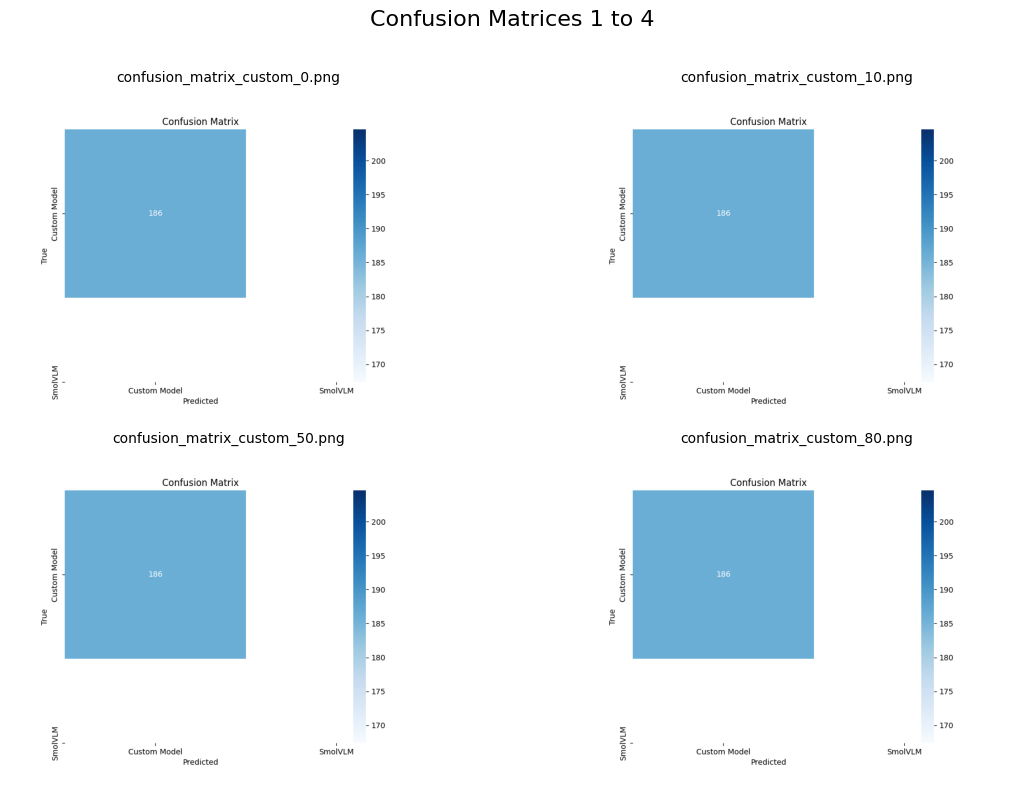

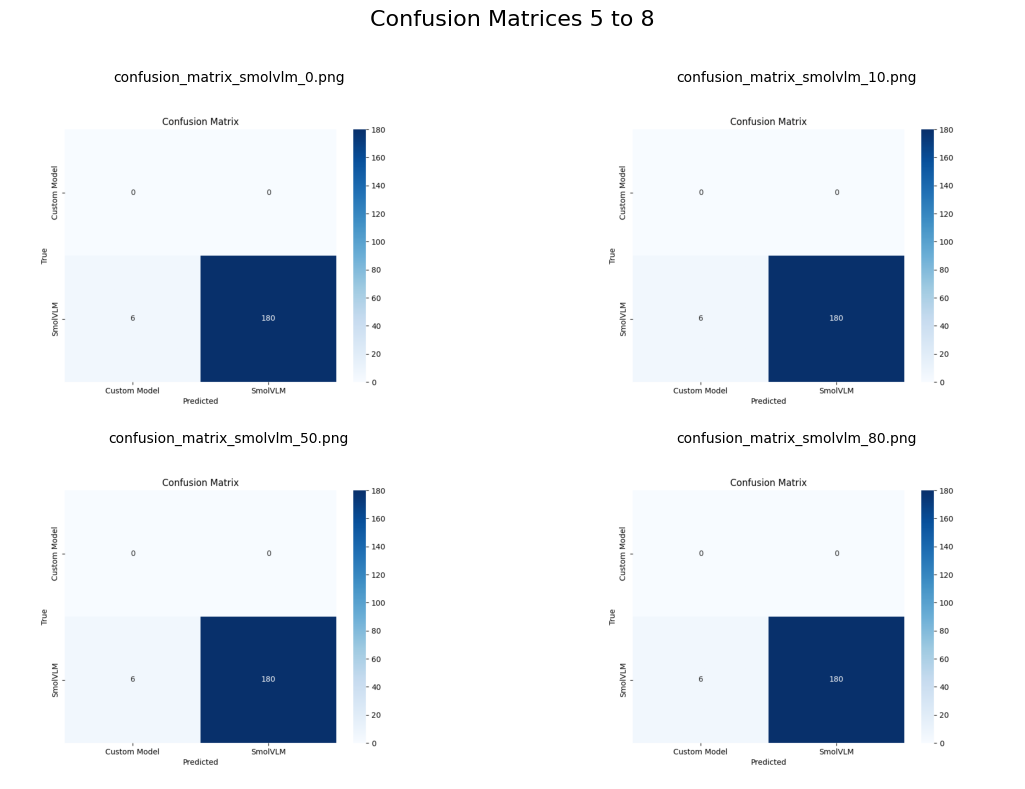

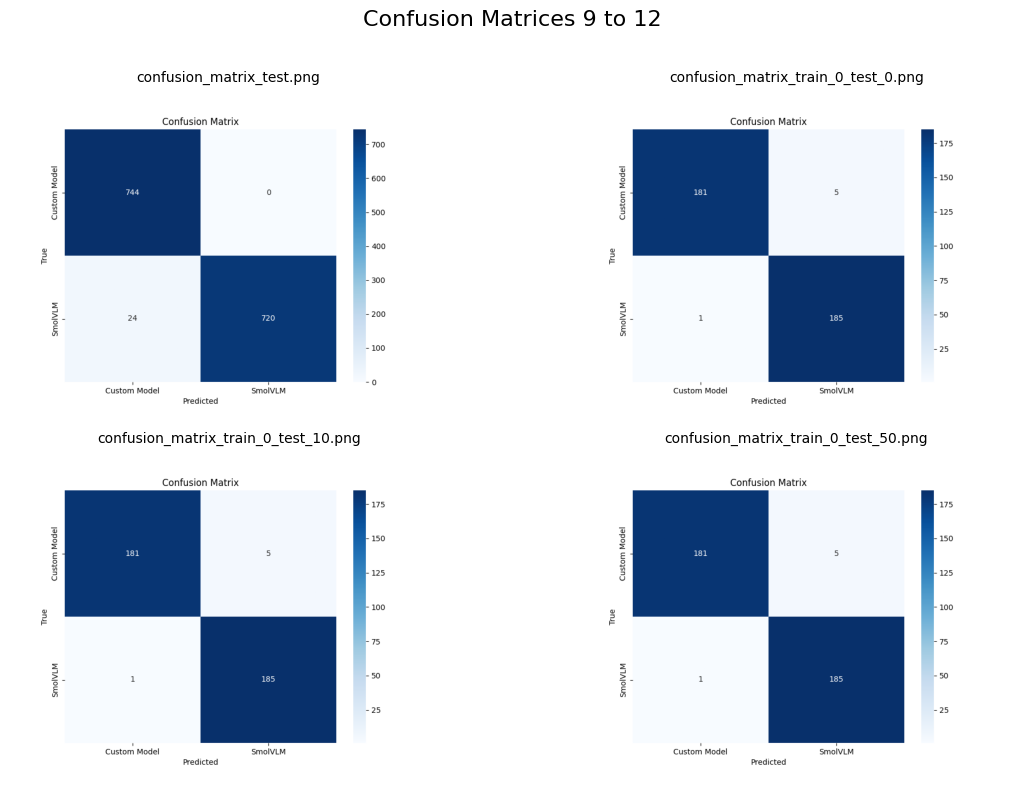

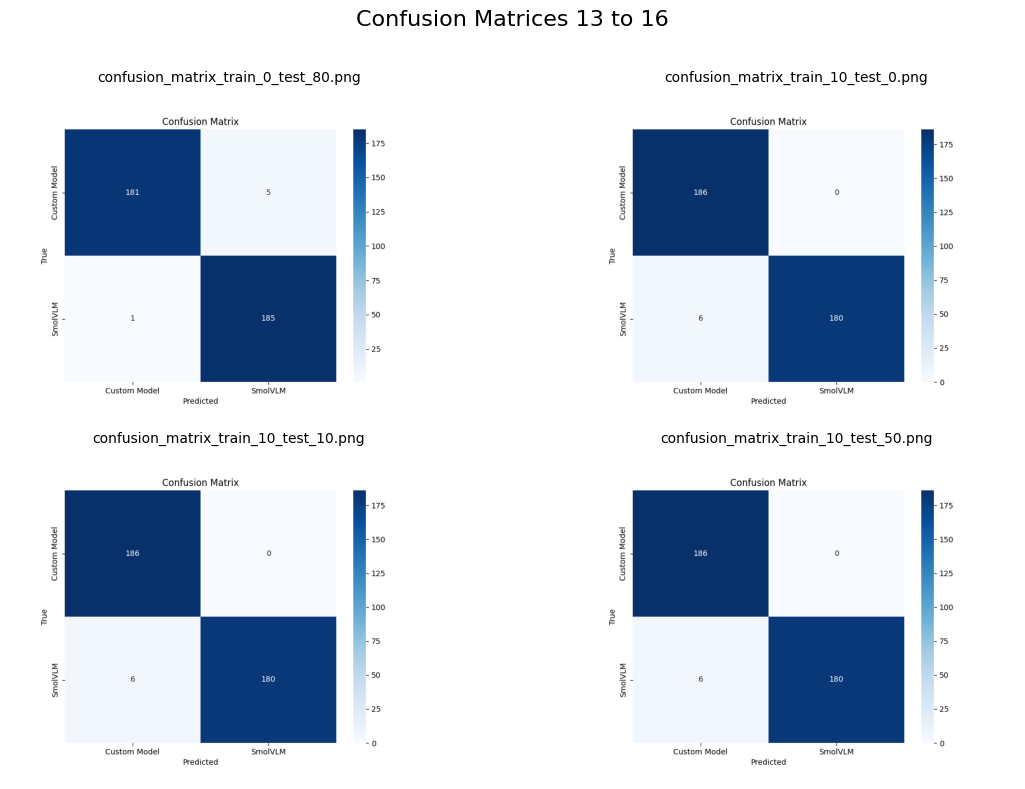

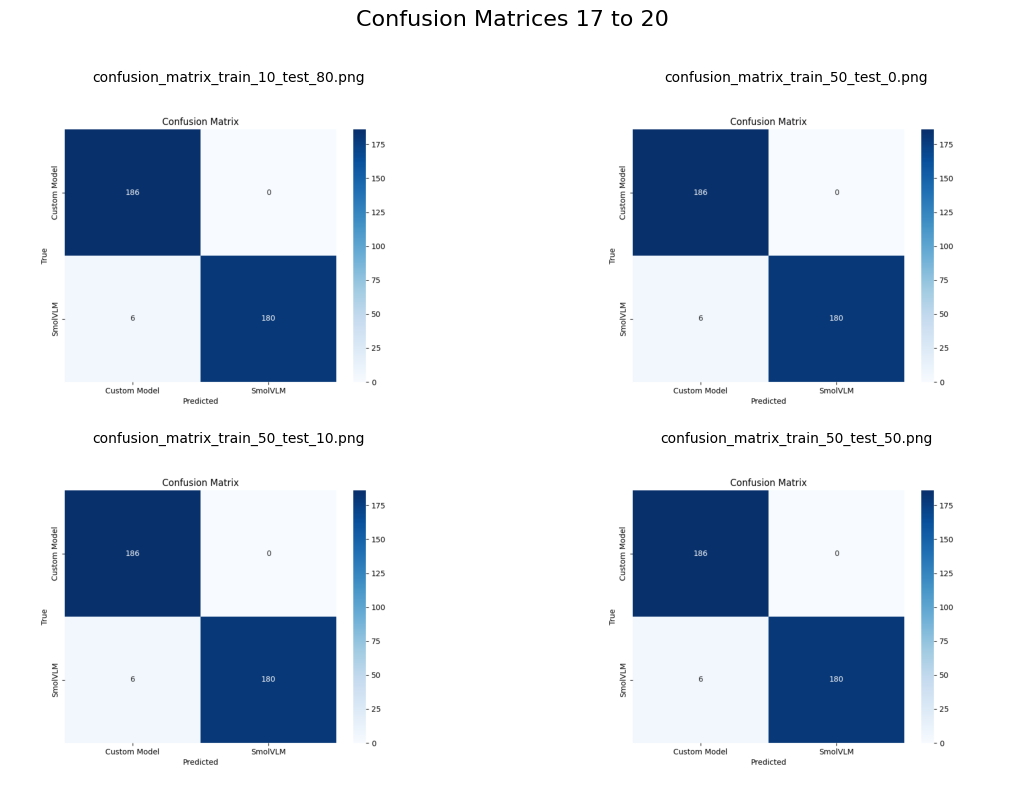

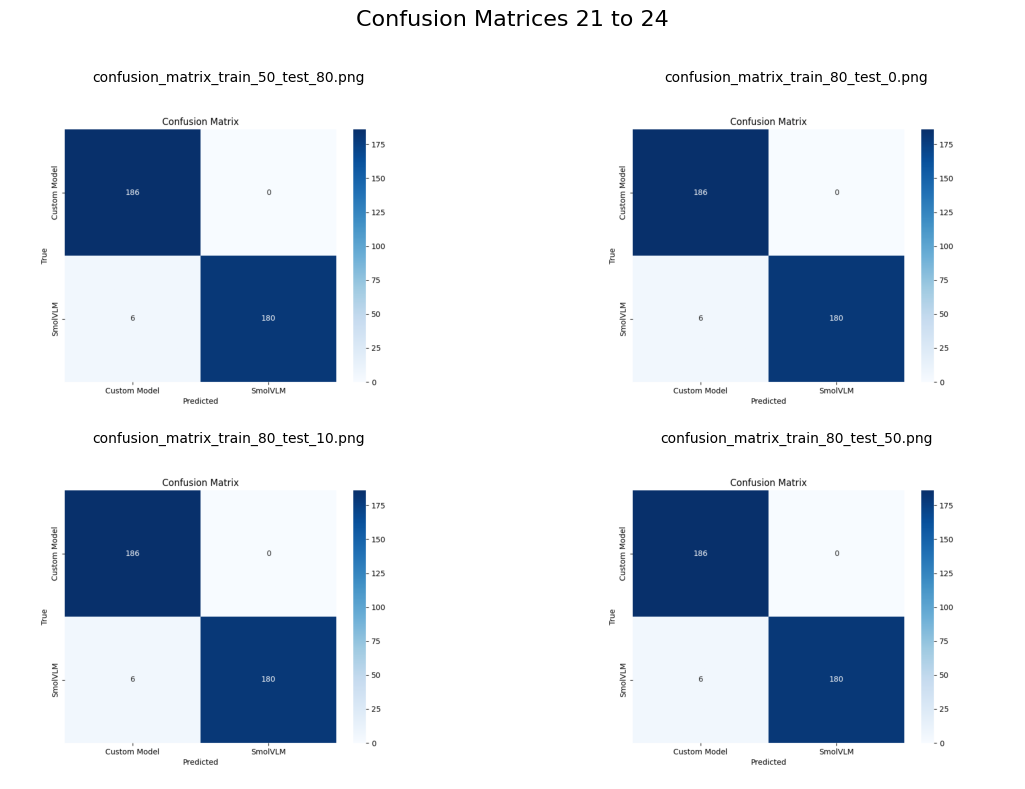

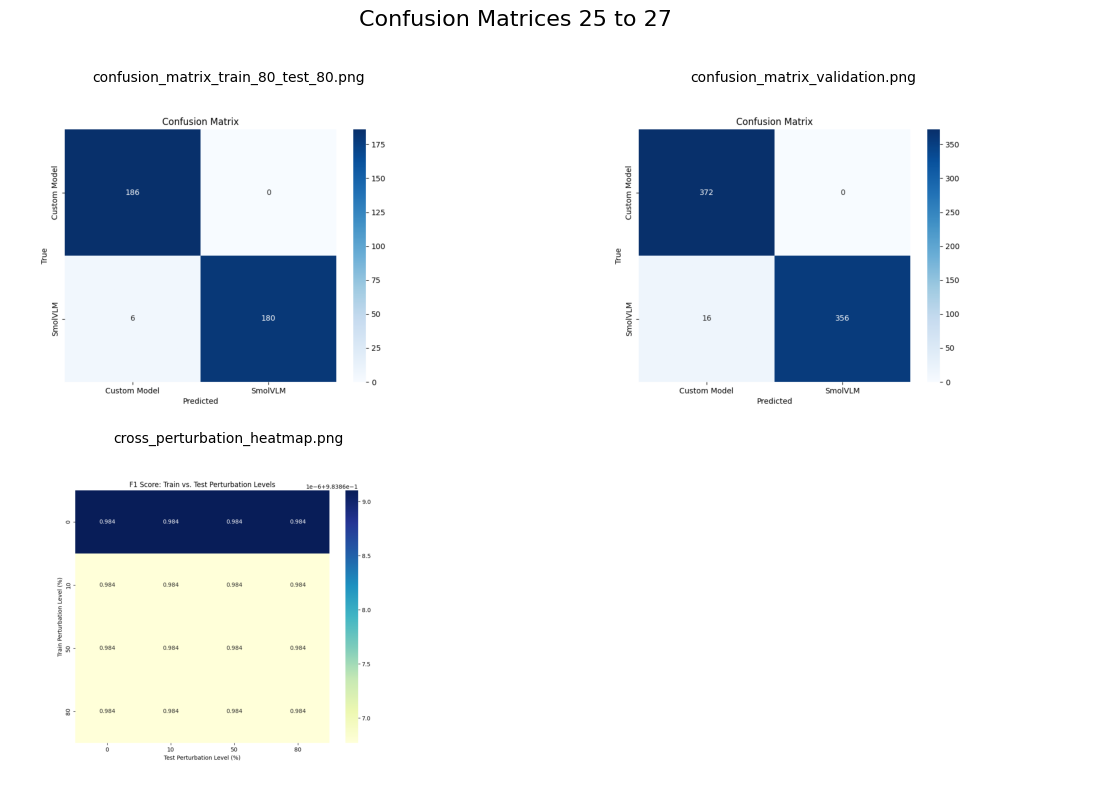

In [1]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

folder_path = '/kaggle/input/conf-matrix' 

image_files = [f for f in os.listdir(folder_path) if f.endswith(('.png', '.jpg', '.jpeg'))]

image_files.sort()

images_per_page = 4
rows, cols = 2, 2

for i in range(0, len(image_files), images_per_page):
    fig, axes = plt.subplots(rows, cols, figsize=(12, 8))
    fig.suptitle(f'Confusion Matrices {i+1} to {min(i+images_per_page, len(image_files))}', fontsize=16)
    
    for j in range(images_per_page):
        idx = i + j
        if idx >= len(image_files):
            axes[j // cols, j % cols].axis('off')
            continue
        
        img_path = os.path.join(folder_path, image_files[idx])
        img = mpimg.imread(img_path)
        axes[j // cols, j % cols].imshow(img)
        axes[j // cols, j % cols].axis('off')
        axes[j // cols, j % cols].set_title(image_files[idx], fontsize=10)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.88)
    plt.show()
